#Предсказание объёма торгов с помощью Catboost


In [ ]:
import math 
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from google.colab import drive
from dateutil.parser import parse
import os


drive.mount("/content/drive")
plt.style.use('fivethirtyeight')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TSLA = pd.read_csv("/content/drive/My Drive/data/shares_data_csv/1min/TSLA.csv")
TSLA

,time,volume,open,close,high,low
0,2022-10-10 09:30:00+03:00,37381.0,223.63,224.60,224.70,222.67
1,2022-10-10 09:31:00+03:00,18291.0,224.50,223.82,225.50,223.75
2,2022-10-10 09:32:00+03:00,11700.0,223.81,222.27,224.26,222.05
3,2022-10-10 09:33:00+03:00,7928.0,222.15,220.80,222.15,220.52
4,2022-10-10 09:34:00+03:00,3124.0,220.79,221.56,221.56,220.79
...,...,...,...,...,...,...
112989,2023-04-28 22:30:00+00:00,51.0,164.05,164.06,164.06,164.05
112990,2023-04-28 22:31:00+00:00,241.0,164.06,164.07,164.07,164.06
112991,2023-04-28 22:32:00+00:00,149.0,164.05,164.05,164.05,164.05
112992,2023-04-28 22:36:00+00:00,3.0,164.05,164.05,164.05,164.05


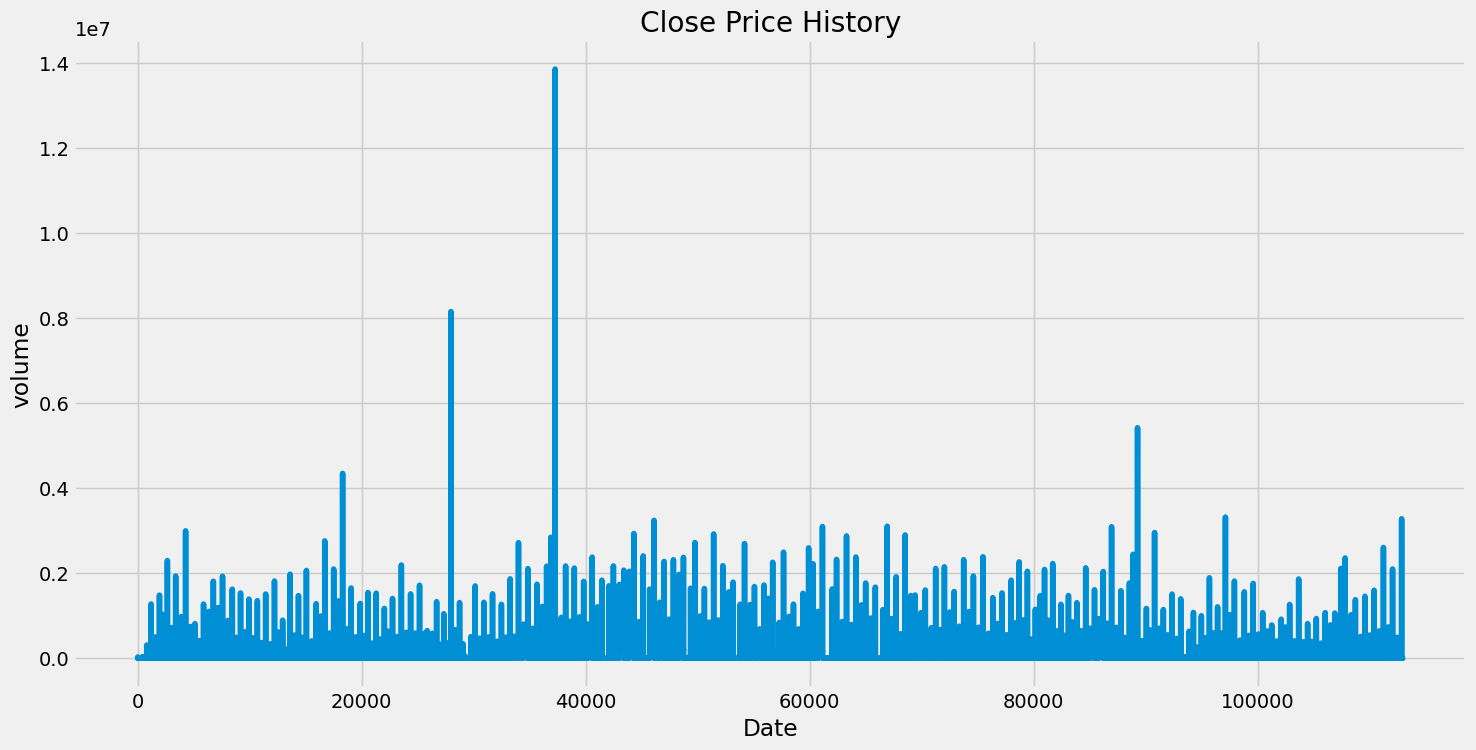

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Close Price History')
plt.plot(TSLA['volume'])
plt.xlabel('Date')
plt.ylabel('volume')
plt.show()

In [ ]:
def make_sma(df,
             window,
             cost_type='open'):
    sma = pd.DataFrame()
    sma[cost_type] = df[cost_type].rolling(window=window).mean()
    return sma


def make_ema(df,
             window,
             cost_type='open'):
    ema = pd.DataFrame()
    ema[cost_type] = df[cost_type].ewm(span=window).mean()
    return ema

In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []
sma_5 = make_sma(TSLA, 5, 'volume')
sma_15 = make_sma(TSLA, 15, 'volume')
sma_30 = make_sma(TSLA, 30, 'volume')
sma_60 = make_sma(TSLA, 60, 'volume')
sma_120 = make_sma(TSLA, 120, 'volume')
sma_180 = make_sma(TSLA, 180, 'volume')
sma_240 = make_sma(TSLA, 240, 'volume')
ema_5 = make_ema(TSLA, 5, 'volume')
ema_15 = make_ema(TSLA, 15, 'volume')
ema_30 = make_ema(TSLA, 30, 'volume')
ema_60 = make_ema(TSLA, 60, 'volume')
ema_120 = make_ema(TSLA, 120, 'volume')
ema_180 = make_ema(TSLA, 180, 'volume')
ema_240 = make_ema(TSLA, 240, 'volume')
for i in range(1000, len(TSLA)):
    temp_X = []
    temp_y = TSLA['volume'].iloc[i]
    date = parse(TSLA['time'].iloc[i])
    temp_X.append(TSLA['volume'].iloc[i-1])
    temp_X.append(TSLA['volume'].iloc[i-2])
    temp_X.append(TSLA['volume'].iloc[i-3])
    temp_X.append(TSLA['volume'].iloc[i-4])
    temp_X.append(TSLA['open'].iloc[i]-TSLA['open'].iloc[i-1])
    temp_X.append(TSLA['open'].iloc[i]-TSLA['open'].iloc[i-2])
    temp_X.append(TSLA['open'].iloc[i]-TSLA['open'].iloc[i-5])
    temp_X.append(TSLA['open'].iloc[i]-TSLA['open'].iloc[i-10])
    temp_X.append(TSLA['open'].iloc[i]-TSLA['open'].iloc[i-30])
    temp_X.append(TSLA['open'].iloc[i]-TSLA['open'].iloc[i-60])
    temp_X.append(TSLA['open'].iloc[i]-TSLA['open'].iloc[i-100])
    temp_X.append(TSLA['open'].iloc[i]-TSLA['open'].iloc[i-200])
    temp_X.append(TSLA['open'].iloc[i]-TSLA['open'].iloc[i-300])
    temp_X.append(TSLA['open'].iloc[i]-TSLA['open'].iloc[i-500])
    temp_X.append(TSLA['open'].iloc[i]-TSLA['open'].iloc[i-1000])
    temp_X.append(sma_5['volume'].iloc[i-1])
    temp_X.append(sma_15['volume'].iloc[i-1])
    temp_X.append(sma_30['volume'].iloc[i-1])
    temp_X.append(sma_60['volume'].iloc[i-1])
    temp_X.append(sma_120['volume'].iloc[i-1])
    temp_X.append(sma_180['volume'].iloc[i-1])
    temp_X.append(sma_240['volume'].iloc[i-1])
    temp_X.append(ema_5['volume'].iloc[i-1])
    temp_X.append(ema_15['volume'].iloc[i-1])
    temp_X.append(ema_30['volume'].iloc[i-1])
    temp_X.append(ema_60['volume'].iloc[i-1])
    temp_X.append(ema_120['volume'].iloc[i-1])
    temp_X.append(ema_180['volume'].iloc[i-1])
    temp_X.append(ema_240['volume'].iloc[i-1])
    temp_X.append(date.day)
    temp_X.append(date.hour)
    temp_X.append(date.minute)
    temp_X.append(date.weekday())
    temp_X.append(i)
    if i < 0.7 * (len(TSLA) - 300):
        if TSLA['volume'].iloc[i] > 400000:
            continue
        X_train.append(temp_X)
        y_train.append(temp_y)
    else:
        X_test.append(temp_X)
        y_test.append(temp_y)

In [ ]:
y_train = np.array(y_train, float)
X_train = np.array(X_train, float)
X_test = np.array(X_test, float)
y_test = np.array(y_test, float)

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train, y_train)


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

In [ ]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

In [ ]:
hard_model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [100, 125, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
hard_model.grid_search(grid, train_dataset)

Выходные данные были обрезаны до нескольких последних строк (5000).
61:	learn: 17703.9198875	test: 18444.0081406	best: 18443.4282190 (58)	total: 2.87s	remaining: 1.76s
62:	learn: 17684.0504973	test: 18441.3632614	best: 18441.3632614 (62)	total: 2.9s	remaining: 1.71s
63:	learn: 17649.7142147	test: 18442.3512604	best: 18441.3632614 (62)	total: 2.96s	remaining: 1.67s
64:	learn: 17616.3608087	test: 18445.3029465	best: 18441.3632614 (62)	total: 3.01s	remaining: 1.62s
65:	learn: 17591.9341861	test: 18446.9344031	best: 18441.3632614 (62)	total: 3.05s	remaining: 1.57s
66:	learn: 17552.2418720	test: 18449.1046751	best: 18441.3632614 (62)	total: 3.14s	remaining: 1.55s
67:	learn: 17536.1601315	test: 18441.9569693	best: 18441.3632614 (62)	total: 3.23s	remaining: 1.52s
68:	learn: 17514.8927971	test: 18437.7864424	best: 18437.7864424 (68)	total: 3.3s	remaining: 1.48s
69:	learn: 17490.0176783	test: 18444.0129728	best: 18437.7864424 (68)	total: 3.38s	remaining: 1.45s
70:	learn: 17466.0254500	test: 184

{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.5},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

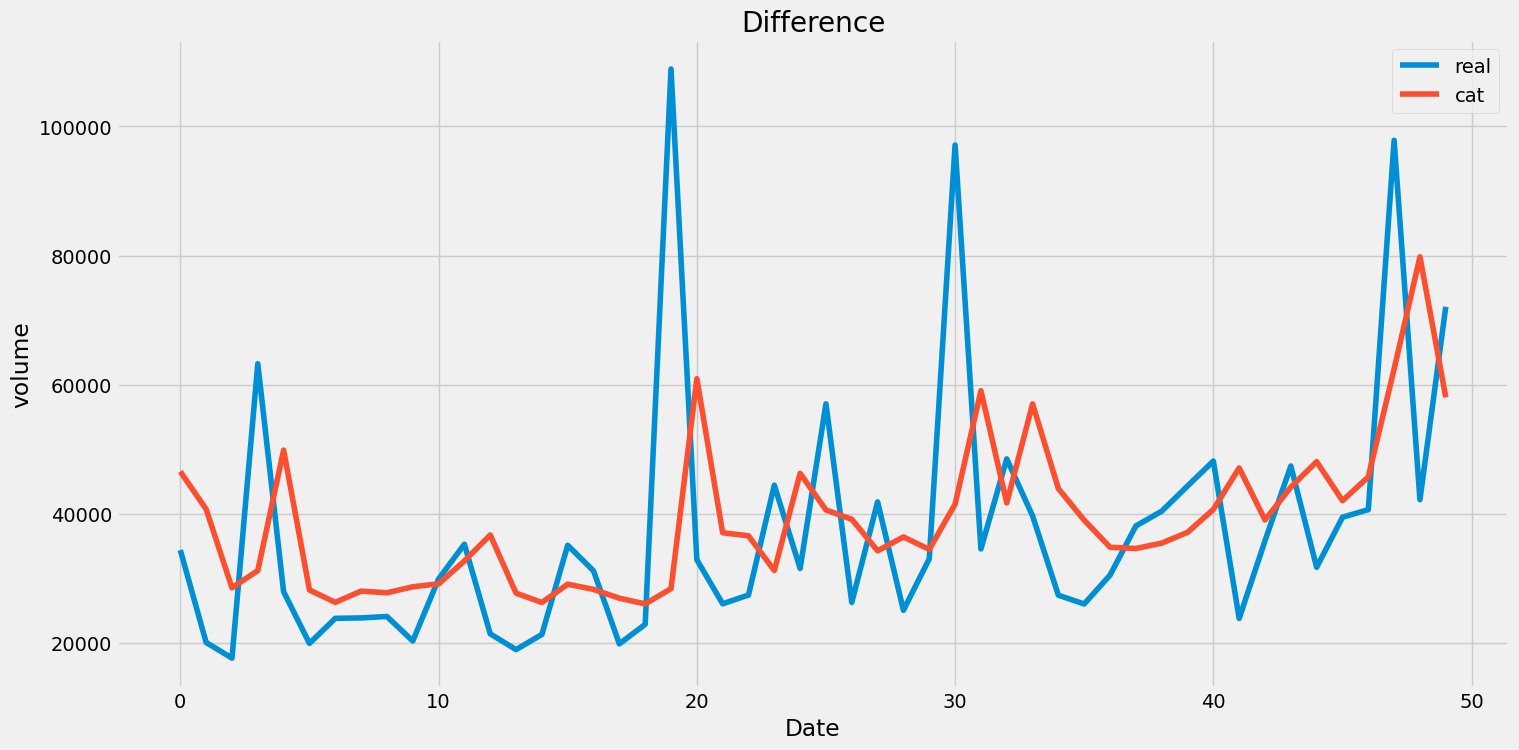

In [ ]:
hard_temp = hard_model.predict(X_test)
plt.figure(figsize = (16,8))
plt.title('Difference')
plt.plot(y_test[500:550], label='real')
plt.plot(hard_temp[500:550], label='cat')
plt.xlabel('Date')
plt.ylabel('volume')
plt.legend()
plt.show()

In [ ]:
print('Catboost Regression')
rmse = (np.sqrt(mean_squared_error(y_test, hard_temp)))
r2 = r2_score(y_test, hard_temp)
print('RMSE: ' + str(rmse))
print('R2: ' + str(r2))

Catboost Regression
RMSE: 74876.18685869953
R2: 0.14540325055589332


In [ ]:
sorted_feature_importance = hard_model.feature_importances_.argsort()
imp = hard_model.feature_importances_[sorted_feature_importance]
for i in range(len(sorted_feature_importance)):
   print(str(sorted_feature_importance[i]) + '  ' + str(imp[i])) 

26  0.31574953090049834
11  0.3162883216095938
32  0.450729740041983
28  0.46924822564194335
20  0.5575064103122501
27  0.6440372852735246
12  0.6905363798480453
19  0.773777408680335
10  0.8457838119111539
14  0.9276384420459081
29  0.9619267150899093
21  0.9619547471941894
25  1.09630645259943
18  1.2138231115827998
13  1.3665278498376592
9  1.3715440567224968
24  1.4382636282002415
33  1.6541184270052331
8  1.8438906640457149
5  1.8602414006053325
17  2.0600548897269175
7  2.0774686776557325
6  2.3490723104209312
3  2.4144135051903426
2  3.0091203799841786
1  3.1250221702447947
4  4.0336475646571435
23  4.5954938319536485
15  5.331055544946674
16  5.471384359207343
30  8.041106835898876
31  9.722959071269377
22  12.55191783963556
0  15.457390410060235
